In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,recall_score, precision_score,f1_score
from imblearn.over_sampling import SMOTE
import shap

c:\Users\Asus\Desktop\credit-card-fraud-xgboost-rf-lgbm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset


In [2]:
df = pd.read_csv("./data/credit_card_transactions.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


# remove columns 'Unnamed: 0'

In [3]:
df = df.drop(columns=["Unnamed: 0"])
#reset the index to be consecutive integers
df = df.reset_index(drop=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


##  downsample dataset to 100,000 rows while preserving the original ratio of fraudulent vs non-fraudulent transactions.


In [4]:
# Define desired number of rows
n_rows = 100000

# Use stratified sampling
df = df.groupby("is_fraud", group_keys=False).apply(
    lambda x: x.sample(frac=n_rows / len(df), random_state=42)
)

# Check the new shape
print(df.shape)
# Check the ratio of fraud vs non-fraud
print(df["is_fraud"].value_counts(normalize=True))

(100000, 23)
is_fraud
0    0.99421
1    0.00579
Name: proportion, dtype: float64


C:\Users\Asus\AppData\Local\Temp\ipykernel_5868\557766383.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("is_fraud", group_keys=False).apply(


In [5]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,Santa Monica,...,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0,NaN
1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,Matthews,...,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0,63870.0
800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,Keisterville,...,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0,21557.0
398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,Heart Butte,...,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0,NaN
207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,Kingsport,...,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0,24614.0


In [6]:
# display summary statistics
print(df.describe())

             cc_num            amt            zip            lat  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   4.214353e+17      69.825856   48780.682330      38.567738   
std    1.314526e+18     150.256459   26937.717614       5.070358   
min    6.041621e+10       1.000000    1257.000000      20.027100   
25%    1.800365e+14       9.660000   26041.000000      34.668900   
50%    3.520550e+15      47.410000   48174.000000      39.401500   
75%    4.651007e+15      82.600000   72042.000000      41.948800   
max    4.992346e+18   13536.840000   99783.000000      66.693300   

                long      city_pop     unix_time      merch_lat  \
count  100000.000000  1.000000e+05  1.000000e+05  100000.000000   
mean      -90.258384  8.789937e+04  1.349275e+09      38.568450   
std        13.787629  2.976825e+05  1.280539e+07       5.101745   
min      -165.672300  2.300000e+01  1.325376e+09      19.033288   
25%       -96.809400  7.430000e+02  1.338900e+09    

In [7]:
#summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 811778 to 154913
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  100000 non-null  object 
 1   cc_num                 100000 non-null  int64  
 2   merchant               100000 non-null  object 
 3   category               100000 non-null  object 
 4   amt                    100000 non-null  float64
 5   first                  100000 non-null  object 
 6   last                   100000 non-null  object 
 7   gender                 100000 non-null  object 
 8   street                 100000 non-null  object 
 9   city                   100000 non-null  object 
 10  state                  100000 non-null  object 
 11  zip                    100000 non-null  int64  
 12  lat                    100000 non-null  float64
 13  long                   100000 non-null  float64
 14  city_pop               100000 non-nu

In [8]:
#columns of dataframe
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

In [9]:
# checking missing values
print(df.isnull().sum())

trans_date_trans_time        0
cc_num                       0
merchant                     0
category                     0
amt                          0
first                        0
last                         0
gender                       0
street                       0
city                         0
state                        0
zip                          0
lat                          0
long                         0
city_pop                     0
job                          0
dob                          0
trans_num                    0
unix_time                    0
merch_lat                    0
merch_long                   0
is_fraud                     0
merch_zipcode            15110
dtype: int64


# Feature Engineering

In [10]:
# convert transaction time to datetime
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_dayofweek"] = df["trans_date_trans_time"].dt.dayofweek  # starting as monday=0
df["trans_month"] = df["trans_date_trans_time"].dt.month
df["trans_is_weekend"] = df["trans_dayofweek"].isin([5, 6]).astype(int)

# extrAct age from dob
df["dob"] = pd.to_datetime(df["dob"])
current_year = datetime.datetime.now().year
df["age"] = current_year - df["dob"].dt.year

In [11]:
# Drop non-predictive columns

drop_cols = [
    "cc_num",
    "first",
    "last",
    "street",
    "state",
    "zip",
    "dob",
    "trans_num",
    "unix_time",
    "merch_lat",
    "merch_long",
    "merch_zipcode",
    "trans_date_trans_time",
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")
df.drop(columns=['job','lat','long'], inplace=True, errors="ignore")

In [12]:
df.head()

,merchant,category,amt,gender,city,city_pop,is_fraud,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
811778,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,F,Santa Monica,92043,0,10,5,12,1,64
1101718,fraud_Lind-Buckridge,entertainment,85.81,F,Matthews,1019,0,13,4,4,0,46
800013,fraud_Hackett-Lueilwitz,grocery_pos,99.30,F,Keisterville,184,0,7,2,12,0,80
398945,fraud_Lynch-Wisozk,home,42.09,F,Heart Butte,743,0,18,6,6,1,53
207455,fraud_Fisher-Schowalter,shopping_net,4.24,F,Kingsport,87124,0,19,0,4,0,38


In [13]:
print(df.columns.tolist())

['merchant', 'category', 'amt', 'gender', 'city', 'city_pop', 'is_fraud', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans_is_weekend', 'age']


In [14]:
# Separate features and target
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]



In [15]:
#feature 
X

,merchant,category,amt,gender,city,city_pop,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
811778,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,F,Santa Monica,92043,10,5,12,1,64
1101718,fraud_Lind-Buckridge,entertainment,85.81,F,Matthews,1019,13,4,4,0,46
800013,fraud_Hackett-Lueilwitz,grocery_pos,99.30,F,Keisterville,184,7,2,12,0,80
398945,fraud_Lynch-Wisozk,home,42.09,F,Heart Butte,743,18,6,6,1,53
207455,fraud_Fisher-Schowalter,shopping_net,4.24,F,Kingsport,87124,19,0,4,0,38
...,...,...,...,...,...,...,...,...,...,...,...
144910,"fraud_Herman, Treutel and Dickens",misc_net,885.76,F,Knoxville,391389,3,1,3,0,31
15454,"fraud_Little, Gutmann and Lynch",shopping_net,937.57,F,Manquin,976,22,2,1,0,26
209208,fraud_Cormier LLC,shopping_net,1094.57,M,Port Charlotte,79008,19,1,4,0,41
71759,fraud_Hills-Witting,shopping_net,853.80,M,Alva,110,22,0,2,0,52


In [16]:
#target
y

811778     0
1101718    0
800013     0
398945     0
207455     0
          ..
144910     1
15454      1
209208     1
71759      1
154913     1
Name: is_fraud, Length: 100000, dtype: int64

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
len(X_train),len(X_test),len(y_train),len(y_test)

(80000, 20000, 80000, 20000)

In [19]:
# List of categorical columns to encode
categorical_cols = [
    "merchant",
    "category",
    "gender",
    "city",
    # "job"
]

# Use LabelEncoder to transform categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [30]:
X_train.head()

,merchant,category,amt,gender,city,city_pop,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
162086,582,3,42.63,0,418,35371,0,2,3,0,37
552458,449,10,88.75,1,770,895,14,5,8,1,26
1182356,118,3,55.23,1,357,190178,2,5,5,1,52
644404,70,9,2.02,1,663,276896,22,0,9,0,28
785291,650,3,77.80,0,95,21125,7,6,12,1,40


In [31]:
X_test.head()

,merchant,category,amt,gender,city,city_pop,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
32709,535,8,3.88,1,163,3807,14,6,1,1,26
403187,215,1,2.28,0,774,46,20,0,7,0,38
1238517,224,12,4.58,0,763,2872,21,6,5,1,38
682221,664,3,58.25,1,333,828,11,4,10,0,34
744261,496,7,129.59,1,140,7297,17,3,11,0,35


# Model Training and MLflow Tracking

In [21]:
# Set up MLflow
mlflow.set_experiment("Credit Card Fraud Detection with RandomForest, XGBoost, LGBM V2.0")

def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test, is_lgbm=False, cat_features=[]):
    """
    trains a model using SMOTE, evaluates it, and logs the results to MLflow.
    Special handling for LightGBM's categorical features.
    """
    with mlflow.start_run(run_name=model_name):
        # log model parameters
        mlflow.log_params(model.get_params())

        # train the model
        print(f"Training {model_name}...")
        if is_lgbm:
            model.fit(X_train, y_train, categorical_feature=cat_features)
        else:
            model.fit(X_train, y_train)

        # make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # calculate metrics
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # log metrics to MLflow
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        # log the trained model as an artifact
        mlflow.sklearn.log_model(model, "model")

        print(f"--- {model_name} Results ---")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print("-" * 20)



# plotting the top 10 feature importance for each model
def plot_feature_importance(model, feature_names, model_name, top_n=10):
    importance = model.feature_importances_
    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(fi_df["Feature"][:top_n][::-1], fi_df["Importance"][:top_n][::-1])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.show()


def explain_model_shap(model, model_name, X_test, top_n=10):
    """
    Generates SHAP values and plots for a trained tree-based model.
    """
    # Initialize the SHAP TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    print(f"\n--- SHAP summary for {model_name} ---")

    # #bar plot: average magnitude of feature contribution
    # shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=top_n, show=True)

    # Beeswarm plot: detailed effect of features
    shap.summary_plot(shap_values, X_test, max_display=top_n, show=True)

Resampled training set: (159074, 11), (159074,)
Starting Random Forest training..
Training Random Forest...


2025/10/08 22:34:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 22:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Random Forest Results ---
Recall: 0.7328
Precision: 0.5120
F1-Score: 0.6028
ROC-AUC: 0.9806
--------------------


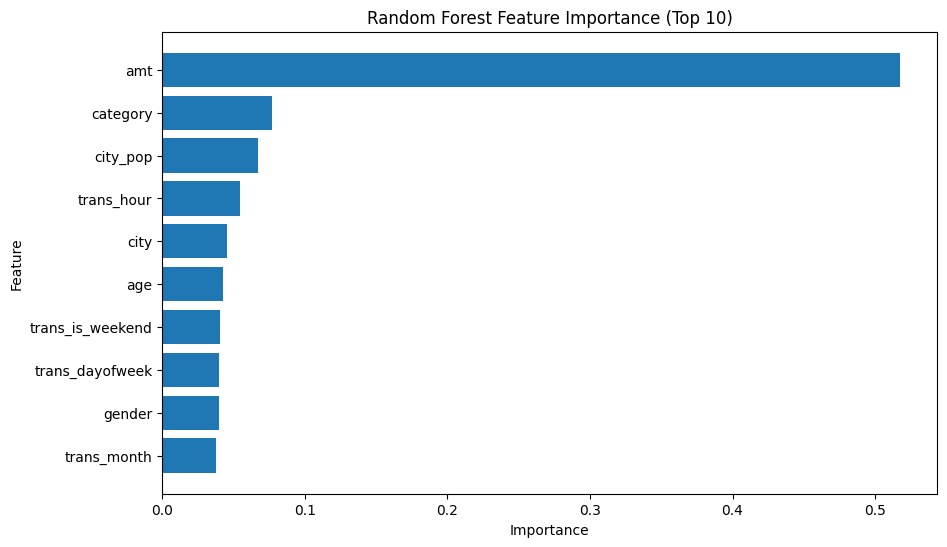

Starting XGBoost training..
Training XGBoost...


2025/10/08 22:34:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 22:34:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- XGBoost Results ---
Recall: 0.8017
Precision: 0.6643
F1-Score: 0.7266
ROC-AUC: 0.9623
--------------------


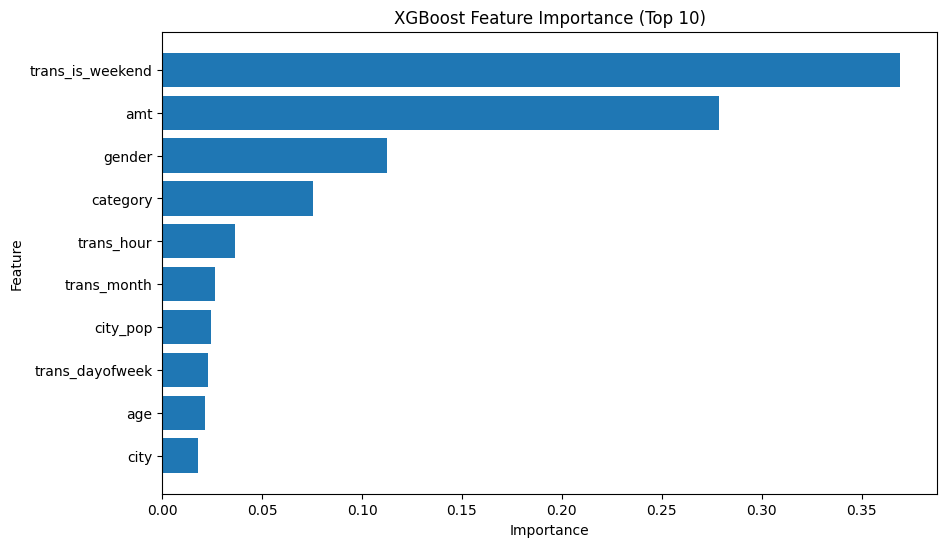

Starting LightGBM training..
Training LightGBM...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 79537, number of negative: 79537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 159074, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/10/08 22:34:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 22:34:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Asus\AppData\Local\Temp\tmpv0_e8_iw\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/08 22:34:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- LightGBM Results ---
Recall: 0.8103
Precision: 0.6026
F1-Score: 0.6912
ROC-AUC: 0.9817
--------------------


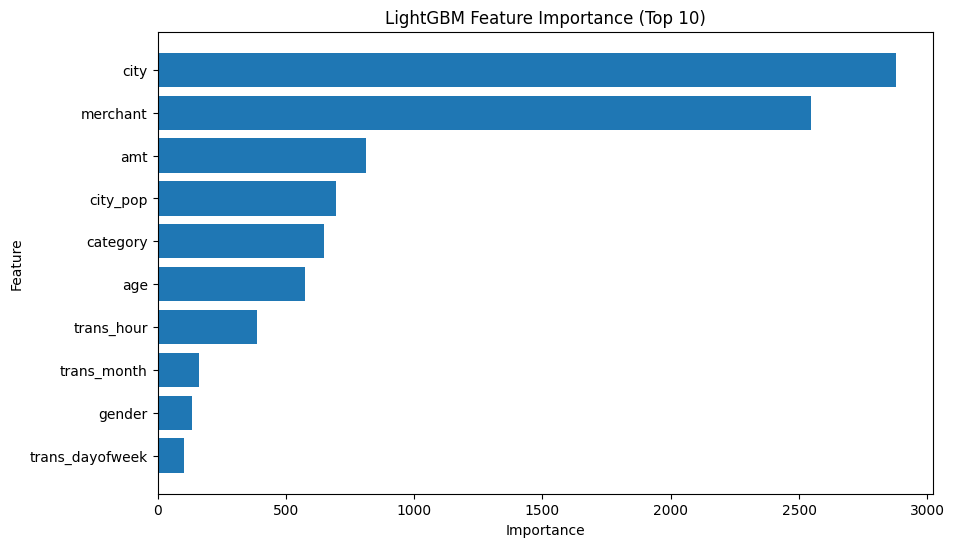

In [22]:
# List of models with their configurations
models = [
    {"name": "Random Forest", "model": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)},
    {"name": "XGBoost", "model": XGBClassifier(n_estimators=300, eval_metric='logloss', random_state=42, n_jobs=-1)},
    {"name": "LightGBM", "model": LGBMClassifier(n_estimators=300, random_state=42, n_jobs=-1), "is_lgbm": True, "cat_features": categorical_cols}
]

# applying SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Resampled training set: {X_train_res.shape}, {y_train_res.shape}")


trained_models = {}
# Loop through models
for m in models:
    print(f"Starting {m['name']} training..")

    # Extract model and optional parameters
    model = m["model"]
    is_lgbm = m.get("is_lgbm", False)
    cat_features = m.get("cat_features", None)

    # Train and log model
    train_and_log_model(
        model,
        m["name"],
        X_train_res,
        y_train_res,
        X_test,
        y_test,
        is_lgbm=is_lgbm,
        cat_features=cat_features,
    )

    # Plot feature importance
    plot_feature_importance(model, X_train.columns, m["name"])

    # Save the trained model
    trained_models[m["name"]] = model

In [29]:
X_test

,merchant,category,amt,gender,city,city_pop,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
32709,535,8,3.88,1,163,3807,14,6,1,1,26
403187,215,1,2.28,0,774,46,20,0,7,0,38
1238517,224,12,4.58,0,763,2872,21,6,5,1,38
682221,664,3,58.25,1,333,828,11,4,10,0,34
744261,496,7,129.59,1,140,7297,17,3,11,0,35
...,...,...,...,...,...,...,...,...,...,...,...
677924,80,5,59.29,0,753,1131,23,1,10,0,66
74192,23,10,4.37,1,317,5732,23,1,2,0,80
421913,451,0,20.60,1,633,198,15,0,7,0,66
847082,268,4,80.89,0,779,5577,1,6,12,1,61


In [23]:
#dict of trained models to be use for SHAP explanation
trained_models

{'Random Forest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=-1,
               num_parallel_tree=None, ...),
 'LightGBM': LGBMClassifier(n_estimators=300, n_jobs=-1, random_state=42)}

c:\Users\Asus\Desktop\credit-card-fraud-xgboost-rf-lgbm\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



--- SHAP summary for LightGBM ---


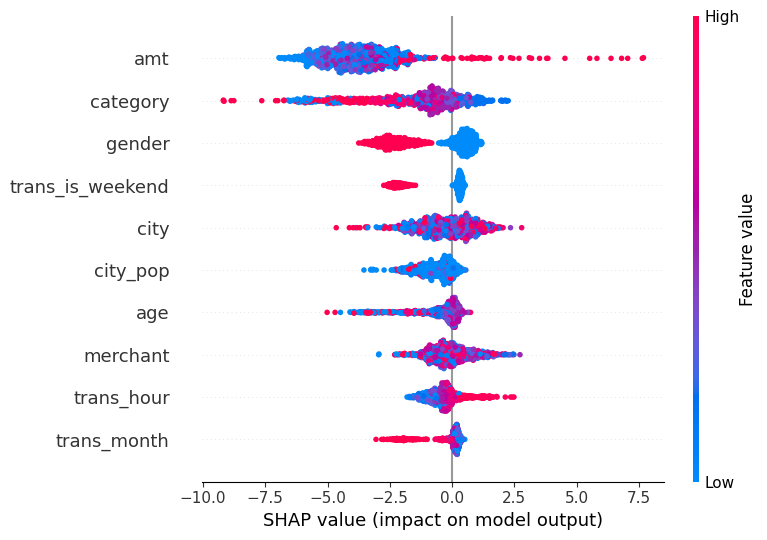

In [33]:
# SHAP explanation for LightGBM
explain_model_shap(trained_models["LightGBM"], "LightGBM", X_test.sample(1000, random_state=42))


--- SHAP summary for XGBoost ---


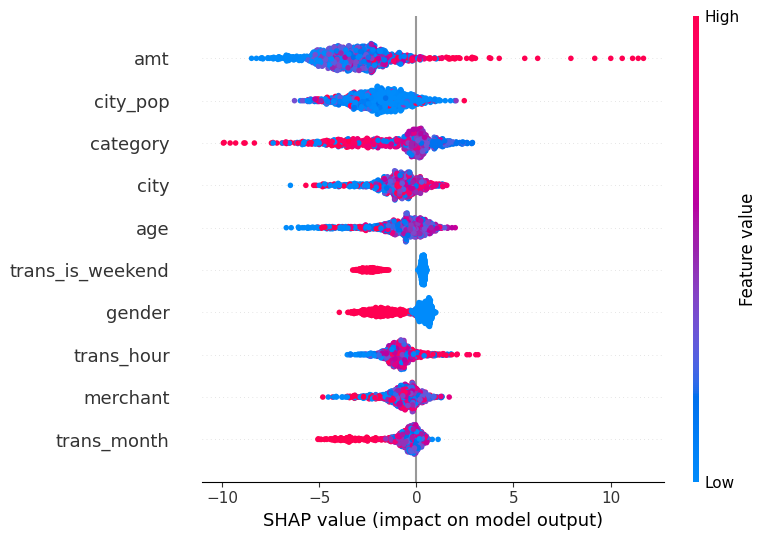

In [25]:
# SHAP explanation for XGBoost
explain_model_shap(
    trained_models["XGBoost"], "XGBoost", X_test.sample(1000, random_state=42)
)